In [1]:
import numpy as np
import pandas as pd
from skopt import gp_minimize, gbrt_minimize 
from skopt.plots import plot_convergence, plot_objective
from rl4greencrab.envs.green_crab_monthly_env import greenCrabMonthEnv
from rl4greencrab.envs.green_crab_monthly_env_norm import greenCrabMonthEnvNormalized
from rl4greencrab.envs.green_crab_movingAvg import greenCrabMonthNormalizedMoving
from rl4greencrab import evaluate_agent, multiConstAction, simulator, environment_simulation, plot_selected_sizes, agent_action_plot
import matplotlib.pyplot as plt
from ipywidgets import interact, widgets
from stable_baselines3 import PPO, TD3
from sb3_contrib import TQC, RecurrentPPO
from rl4greencrab import LipschitzPPO
import seaborn as sns
from rl4greencrab import plot_agent, state_heatmap
import ray

2025-07-31 01:31:44,092	INFO util.py:154 -- Outdated packages:
  ipywidgets==7.8.5 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


In [2]:
config = {
    "w_mort_scale" : 600,
    "growth_k": 0.70,
    'random_start':True,
    'var_penalty_const': 0
    # "curriculum": True
}
env = greenCrabMonthEnv(config)

In [3]:
noInterventionDataDF =  pd.read_csv("rl4greencrab/data/sim_rep500/zero_constant_sim_500.csv")
optimalDataDF = pd.read_csv("rl4greencrab/data/sim_rep500/optimal_constant_sim_500.csv")
tqcDataDF =  pd.read_csv("rl4greencrab/data/sim_rep500/tqc_sim_500.csv")
ppoDataDF = pd.read_csv("rl4greencrab/data/sim_rep500/ppo_sim_500.csv")
rppoDataDF = pd.read_csv("rl4greencrab/data/sim_rep500/rppo_sim_500.csv")

In [4]:
rppo_plot_agent = plot_agent(env_sim_df=rppoDataDF, agent_name='rppo_agent', save_dir = './ppo_plot')
tqc_plot_agent = plot_agent(env_sim_df=tqcDataDF, agent_name='tqc_agent', save_dir = './tqc_plot')

In [5]:
tqcDataDF[tqcDataDF['t']==99]

,t,obs0,obs1,act0,act1,act2,rew,rep,crab_pop
99,99,-0.972789,-0.754594,-0.964028,-0.478759,-0.964028,-4.272806,0,[721.8379342248464 5359.825744287799 4193.0624...
199,99,-0.978526,-0.720904,-0.964028,-0.438457,-0.964028,-3.005812,1,[73.44791348816639 1098.93829177033 4308.38265...
299,99,-0.982762,-0.691896,-0.901654,-0.805281,-0.957725,-2.259945,2,[7.387374258722004 171.59203923461837 1300.333...
399,99,-0.981757,-0.672895,-0.876029,-0.771368,-0.964028,-4.147832,3,[0.7944140160988651 25.620842432684476 301.491...
499,99,-0.956746,-0.859017,0.044922,0.666987,-0.937675,-3.509248,4,[0.4828336007624689 20.187065094161692 323.903...
...,...,...,...,...,...,...,...,...,...
49599,99,-0.971441,-0.716429,-0.964028,-0.594737,-0.958998,-4.551205,495,[691.7443500896177 5136.373416116704 4018.2528...
49699,99,-0.908788,-0.771013,-0.964028,-0.964028,-0.936125,-3.037118,496,[46.693825535877295 702.8030575748143 2766.762...
49799,99,-0.984076,-0.675442,-0.877151,-0.814077,-0.959150,-5.156335,497,[7.691850150672771 176.27077630354424 1332.619...
49899,99,-0.971183,-0.767956,-0.960809,0.418473,-0.964028,-2.306837,498,[3.9943674983697086 131.93143895457965 1556.07...


In [40]:
rppoDataDF[rppoDataDF['t']==99]

,t,obs0,obs1,act0,act1,act2,rew,rep,crab_pop
99,99,-1.000000,-1.000000,-1.0,-0.760282,-1.000000,-4.243903,0,[700.579509005849 5201.976662647511 4069.57354...
199,99,-0.982368,-0.734450,-1.0,-1.000000,-1.000000,-2.748496,1,[70.47876067762886 1065.5618141804184 4209.754...
299,99,-1.000000,-1.000000,-1.0,-0.805902,-0.933653,-1.424419,2,[7.276059627462433 168.38520873491325 1273.606...
399,99,-0.952850,-0.652682,-1.0,-1.000000,-1.000000,-4.393560,3,[0.789380246572119 24.762743078179458 291.2441...
499,99,-1.000000,-1.000000,-1.0,-0.808508,-1.000000,-3.259741,4,[0.48715964561038566 20.98440170814885 341.391...
...,...,...,...,...,...,...,...,...,...
49599,99,-1.000000,-1.000000,-1.0,-0.760282,-1.000000,-5.404576,495,[581.6003820399131 4318.52712684586 3378.43828...
49699,99,-0.964918,-0.807045,-1.0,-1.000000,-1.000000,-2.802318,496,[14.302263785427913 213.72962184830504 838.147...
49799,99,-1.000000,-1.000000,-1.0,-0.805902,-0.933653,-5.833306,497,[6.42365058699724 149.20123739497825 1132.7548...
49899,99,-0.931041,-0.683292,-1.0,-1.000000,-1.000000,-1.516043,498,[4.604053118485602 141.4915872094215 1633.9242...


In [45]:
optimalDataDF[optimalDataDF['t']==99]

,t,obs0,obs1,act0,act1,act2,rew,rep,crab_pop
99,99,-0.881598,-0.755811,-1.0,-1.0,-0.897074,-6.141754,0,[716.4222319839159 5319.666103736417 4161.9205...
199,99,-0.885873,-0.732415,-1.0,-1.0,-0.897074,-3.849940,1,[71.72746878323863 1088.9123370711166 4315.574...
299,99,-0.894682,-0.706286,-1.0,-1.0,-0.897074,-2.097649,2,[7.390248805525682 172.07209831192702 1304.721...
399,99,-0.943519,-0.696347,-1.0,-1.0,-0.897074,-6.011385,3,[0.7958470027310903 25.837614343884127 300.497...
499,99,-0.865793,-0.802984,-1.0,-1.0,-0.897074,-4.036487,4,[0.48140158839645014 19.975579088207045 325.62...
...,...,...,...,...,...,...,...,...,...
49599,99,-0.978237,-0.527258,-1.0,-1.0,-0.897074,-7.495826,495,[552.7418608301302 4104.133932982524 3210.1329...
49699,99,-0.276502,-0.732470,-1.0,-1.0,-0.897074,-3.815246,496,[3.3884404713050782e-12 7.029174600980552e-07 ...
49799,99,-0.994689,-0.424627,-1.0,-1.0,-0.897074,-7.817475,497,[6.313778100407854 146.26085295380258 1111.789...
49899,99,-0.914502,-0.729946,-1.0,-1.0,-0.897074,-2.143637,498,[4.195426163731801 134.68232712811252 1568.262...


In [18]:
t = ppoDataDF[ppoDataDF['t']==99]['rew'] > tqcDataDF[tqcDataDF['t']==99]['rew']
t = t[t == True]
t.index

Index([  399,   599,   699,   799,   899,  1299,  1399,  1499,  1699,  2199,
       ...
       48199, 48399, 48799, 48999, 49099, 49199, 49399, 49499, 49599, 49799],
      dtype='int64', length=215)

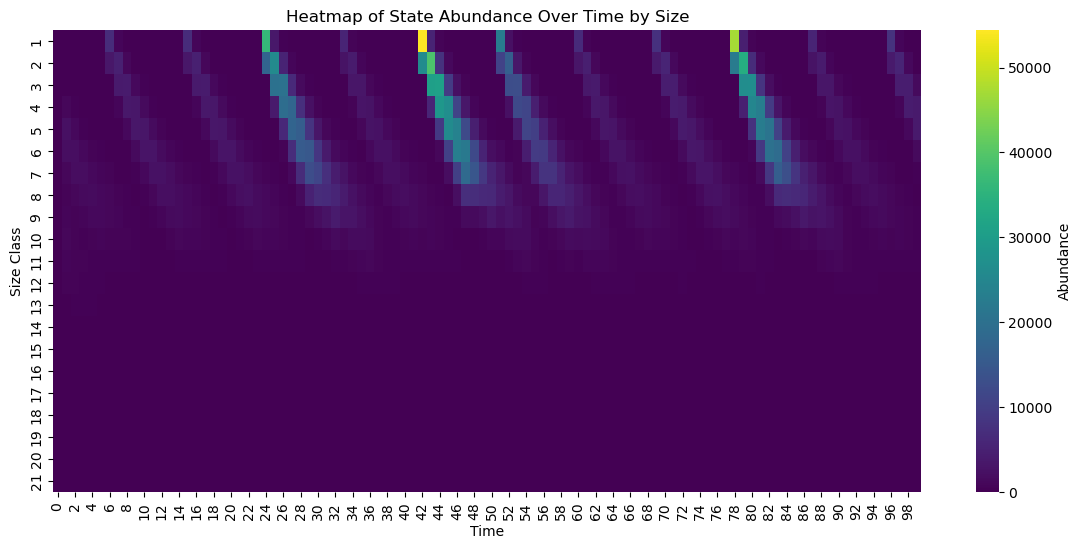

In [9]:
fig = state_heatmap(tqcDataDF, rep=497, use_log=False)

Saved ./tqc_plot/tqc_agent/actions_over_time.png


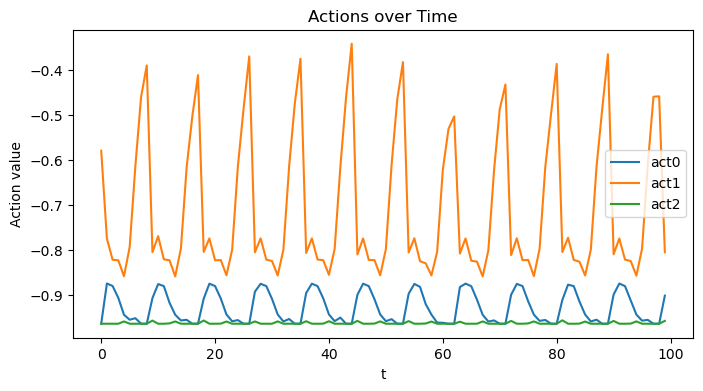

In [7]:
tqc_plot_agent.agent_action_overtime_plots(rep=2)

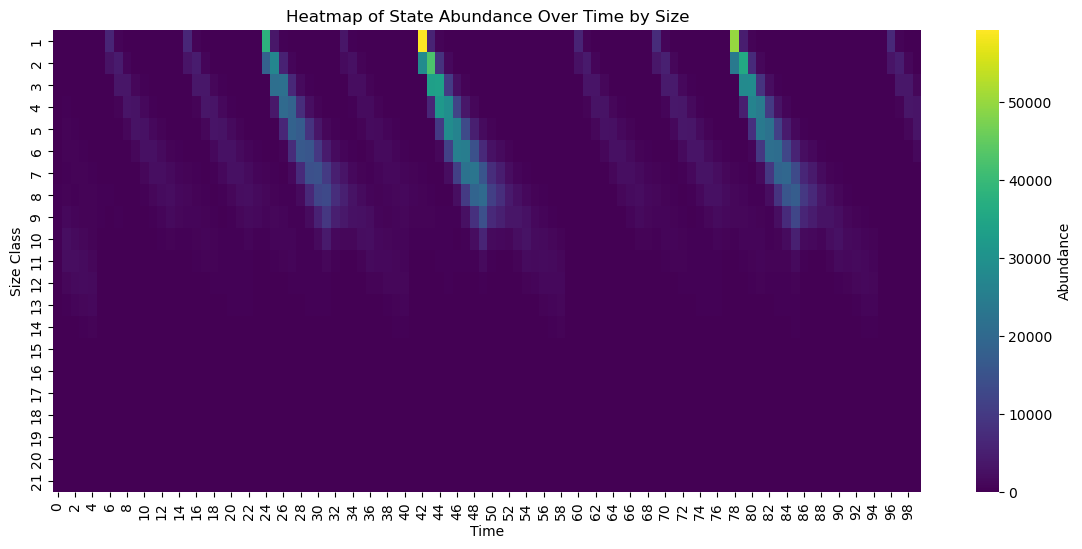

In [10]:
fig = state_heatmap(rppoDataDF, rep=497, use_log=False)

Saved ./ppo_plot/rppo_agent/actions_over_time.png


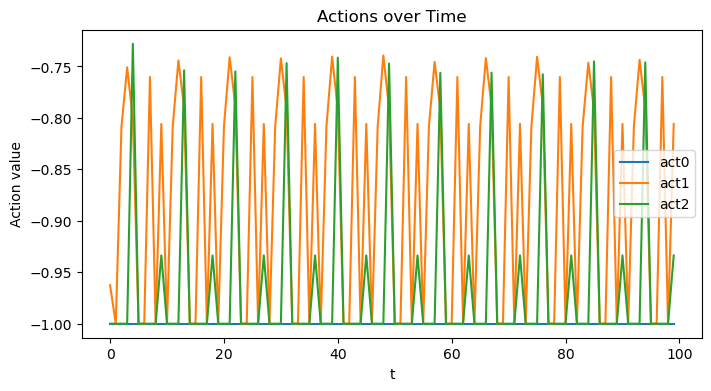

In [8]:
rppo_plot_agent.agent_action_overtime_plots(rep=2)

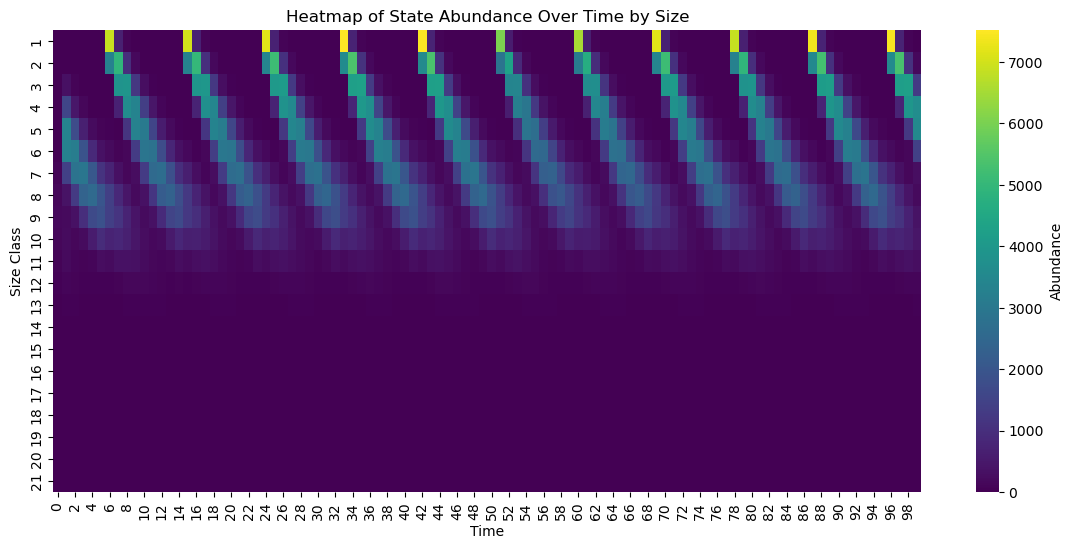

In [44]:
fig = state_heatmap(optimalDataDF, rep=2, use_log=False)

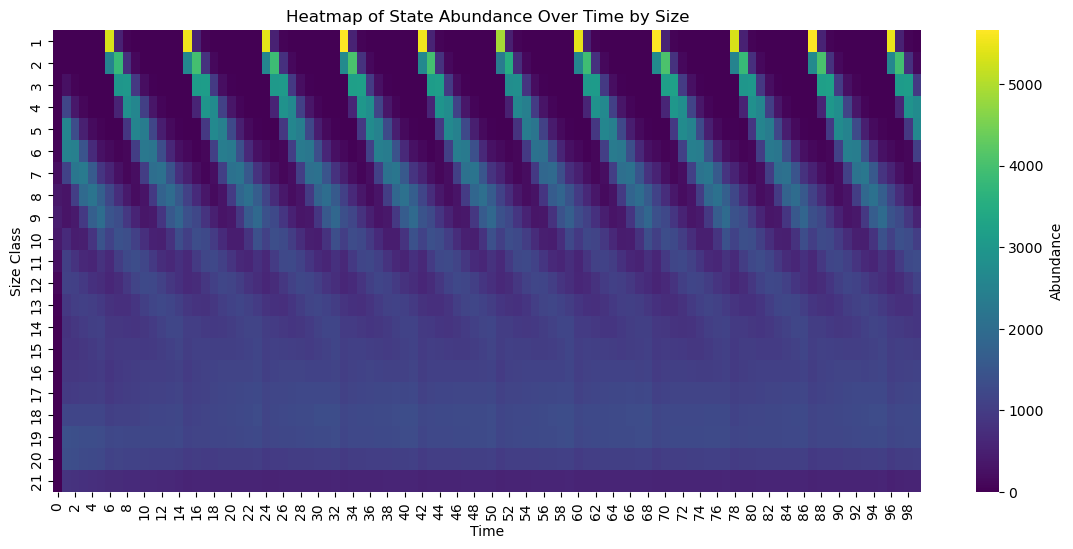

In [46]:
fig = state_heatmap(noInterventionDataDF, rep=2, use_log=False)

In [23]:
fig.savefig("my_seaborn.png")